# Future-Hist for 8 upper atm variables. 
w/ MPAS - Rain signals include MPAS model.

<Details>

* this version loads netcdf files directly via xarray
* "Gridmet data" can now be replaced with any model's output

### TODO items

* better graphs (i.e. include lat/lon scale)


In [1]:
from IPython import display
import numpy as np

#from skimage.metrics import structural_similarity as ssim
import copy


In [2]:
# load netcdf files directly via xarray
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy

# Configuration

In [3]:
# Ordering: nRow ordering: obs, raw, RegCM4, WRF, MPAS, CNN, SDSM, KDDM, MBCn, LOCA
mpi_sigfiles=['/glade/work/mcginnis/DCA/data/gen/final/gridmet/hist/prec.hist.gridMET.obs.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpi/hist/prec.hist.MPI-ESM-LR.raw.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpi/rcp85/prec.rcp85.MPI-ESM-LR.raw.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/regcm4/hist/prec.hist.MPI-ESM-LR.RegCM4.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/regcm4/rcp85/prec.rcp85.MPI-ESM-LR.RegCM4.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/wrf/hist/prec.hist.MPI-ESM-LR.WRF.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/wrf/rcp85/prec.rcp85.MPI-ESM-LR.WRF.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpas/hist/prec.hist.MPI-ESM-LR.MPAS.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpas/rcp85/prec.rcp85.MPI-ESM-LR.MPAS.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/cnn/hist/prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/cnn/rcp85/prec.rcp85.MPI-ESM-LR.CNN.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/sdsm/hist/prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/sdsm/rcp85/prec.rcp85.MPI-ESM-LR.SDSM.day.2070-2099.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/kddm/hist/prec.hist.MPI-ESM-LR.KDDM.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/kddm/rcp85/prec.rcp85.MPI-ESM-LR.KDDM.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mbcn/hist/prec.hist.MPI-ESM-LR.MBCn.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mbcn/rcp85/prec.rcp85.MPI-ESM-LR.MBCn.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/loca/hist/prec.hist.MPI-ESM-LR.LOCA.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/loca/rcp85/prec.rcp85.MPI-ESM-LR.LOCA.day.2075-2100.NAM-22i.SGP.x098.y36.nc']

# Compact Configuration

In [4]:
sigdir = '/glade/work/mcginnis/DCA/data/gen/final'
def model2absfilepath(mn, exp, x, y):
    if mn == 'obs' or mn == 'gridMET':
        mn = 'gridMET'
        filename = 'prec.{}.gridMET.{}.day.1980-2005.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, 'obs', x, y)
    elif mn == 'raw' or mn == 'mpi':
        mn = 'mpi'
        if exp == 'hist':
            filename = 'prec.{}.MPI-ESM-LR.{}.day.1980-2005.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, 'raw', x, y)
        elif exp == 'rcp85':
            filename = 'prec.{}.MPI-ESM-LR.{}.day.2075-2100.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, 'raw', x, y)
        else: print("Unknown experiment!")
    elif mn == 'SDSM':  # starts at 1976
        if exp == 'hist':
            filename = 'prec.{}.MPI-ESM-LR.{}.day.1976-2005.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, mn, x, y)
        elif exp == 'rcp85':
            filename = 'prec.{}.MPI-ESM-LR.{}.day.2070-2099.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, mn, x, y)
        else: print("Unknown experiment!")

    elif exp == 'hist':
        filename = 'prec.{}.MPI-ESM-LR.{}.day.1980-2005.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, mn, x, y)
    elif exp == 'rcp85':
        filename = 'prec.{}.MPI-ESM-LR.{}.day.2075-2100.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, mn, x, y)
    else: print("Unknown experiment!")
    return sigdir + '/' + mn.lower() + '/' + exp + '/' + filename
    

In [5]:
# test single file
model2absfilepath('RegCM4', 'rcp85', 98, 36)

'/glade/work/mcginnis/DCA/data/gen/final/regcm4/rcp85/prec.rcp85.MPI-ESM-LR.RegCM4.day.2075-2100.NAM-22i.SGP.x098.y36.nc'

In [6]:
# create list of abs filepaths
[model2absfilepath(ff, 'hist', 98, 36) for ff in ['obs','raw','RegCM4','WRF','MPAS','CNN','SDSM','KDDM','MBCn','LOCA']]


['/glade/work/mcginnis/DCA/data/gen/final/gridmet/hist/prec.hist.gridMET.obs.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/mpi/hist/prec.hist.MPI-ESM-LR.raw.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/regcm4/hist/prec.hist.MPI-ESM-LR.RegCM4.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/wrf/hist/prec.hist.MPI-ESM-LR.WRF.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/mpas/hist/prec.hist.MPI-ESM-LR.MPAS.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/cnn/hist/prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/sdsm/hist/prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/kddm/hist/prec.hist.MPI-ESM-LR.KDDM.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/mbcn/hist/prec.hi

### Load model output data

In [7]:
##################
## LOAD GRIDMET ##
##################
# 1980-1989
istart = 365
#ndays = 3653  # 1980-1989
ndays = 13515 # 1980-2016 

dv1 = xr.open_dataset('/glade/work/dkorytin/srgan_data/prec128_gridmetA_1979-2016.nc')['prec'][istart:istart+ndays]
# dv2 = xr.open_dataset('/glade/work/dkorytin/srgan_data/tmax128_gridmetA_1979-2016.nc')['tmax'][istart:istart+ndays]
# dv3 = xr.open_dataset('/glade/work/dkorytin/srgan_data/tmin128_gridmetA_1979-2016.nc')['tmin'][istart:istart+ndays]
# dv4 = xr.open_dataset('/glade/work/dkorytin/srgan_data/uas128_gridmetA_1979-2016.nc')['uas'][istart:istart+ndays]
# dv5 = xr.open_dataset('/glade/work/dkorytin/srgan_data/vas128_gridmetA_1979-2016.nc')['vas'][istart:istart+ndays]
# dv6 = xr.open_dataset('/glade/work/dkorytin/srgan_data/huss128_gridmetA_1979-2016.nc')['huss'][istart:istart+ndays]
# dv7 = xr.open_dataset('/glade/work/dkorytin/srgan_data/rsds128_gridmetA_1979-2016.nc')['rsds'][istart:istart+ndays]
# dv8 = xr.open_dataset('/glade/work/dkorytin/srgan_data/miss128_gridmetB_1979-2016.nc')['miss'][istart:istart+ndays]




### Load MPI UATM data

In [8]:
###########################
## LOAD ERAI data: daily ##
###########################
def load_uatm_erai():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    # load eraionmpi
    #mndays = 11688      # 1979-2010
    mstart = 365
    mndays = 13515       # 1980-2016 
    mnvars = 8*1
    mdv1 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/U850.ERAI.MPIGRID.1979-2018.nc')['U'][mstart:mstart+mndays*1]
    mdv2 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/V850.ERAI.MPIGRID.1979-2018.nc')['V'][mstart:mstart+mndays*1]
    mdv3 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Q850.ERAI.MPIGRID.1979-2018.nc')['Q'][mstart:mstart+mndays*1]
    mdv4 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/T700.ERAI.MPIGRID.1979-2018.nc')['T'][mstart:mstart+mndays*1]
    mdv5 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Z700.ERAI.MPIGRID.1979-2018.nc')['Z'][mstart:mstart+mndays*1]
    mdv6 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Z500.ERAI.MPIGRID.1979-2018.nc')['Z'][mstart:mstart+mndays*1]
    mdv7 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/U250.ERAI.MPIGRID.1979-2018.nc')['U'][mstart:mstart+mndays*1]
    mdv8 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/V250.ERAI.MPIGRID.1979-2018.nc')['V'][mstart:mstart+mndays*1]

    print("Days loaded", len(mdv7))


In [9]:
###################
## LOAD MPI      ##
###################  
def load_uatm_mpi_hist():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    mnvars = 8
    
    d='/glade/p/ral/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/historical/'

    mdv1 = xr.open_dataset(d+'U_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['U'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv2 = xr.open_dataset(d+'V_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['V'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv3 = xr.open_dataset(d+'Q_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['Q'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv4 = xr.open_dataset(d+'T_MPI-ESM-LR_historical_r1i1p1_NAmerica_p700_19500101-20051231_dayavg_mpigrid.nc')['T'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv5 = xr.open_dataset(d+'Z_MPI-ESM-LR_historical_r1i1p1_NAmerica_p700_19500101-20051231_dayavg_mpigrid.nc')['Z'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv6 = xr.open_dataset(d+'Z_MPI-ESM-LR_historical_r1i1p1_NAmerica_p500_19500101-20051231_dayavg_mpigrid.nc')['Z'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv7 = xr.open_dataset(d+'U_MPI-ESM-LR_historical_r1i1p1_NAmerica_p250_19500101-20051231_dayavg_mpigrid.nc')['U'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv8 = xr.open_dataset(d+'V_MPI-ESM-LR_historical_r1i1p1_NAmerica_p250_19500101-20051231_dayavg_mpigrid.nc')['V'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))

def load_uatm_mpi_future():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    d='/glade/p/ral/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/rcp85/'

    mnvars = 8
    mdv1 = xr.open_dataset(d+'U_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['U'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv2 = xr.open_dataset(d+'V_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['V'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv3 = xr.open_dataset(d+'Q_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['Q'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv4 = xr.open_dataset(d+'T_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p700_20060101-21001231_dayavg_mpigrid.nc')['T'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv5 = xr.open_dataset(d+'Z_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p700_20060101-21001231_dayavg_mpigrid.nc')['Z'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv6 = xr.open_dataset(d+'Z_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p500_20060101-21001231_dayavg_mpigrid.nc')['Z'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv7 = xr.open_dataset(d+'U_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p250_20060101-21001231_dayavg_mpigrid.nc')['U'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv8 = xr.open_dataset(d+'V_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p250_20060101-21001231_dayavg_mpigrid.nc')['V'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))

#load_uatm_mpi_future()


# Averaging code

In [10]:
###################
## UATM averages ##
###################

def calc_uatm_average(mpr_min, mpr_max, rainsignal, ymin, ymax):
    # global inputs: dv[1-8], mdv[1-8], mnvars
    mnvars = 8
    
    # initialize accumulators
    indices = []
    distribution = []
    raw_ires = len(mdv1[0])
    raininput = np.zeros((mnvars, raw_ires, raw_ires))
    raincount = 0
    
    for ii in range(0,len(rainsignal)):
        mpr = rainsignal[ii]
            
        # May = 5
        if mpr["time.month"] == 5 and mpr["time.year"] >= ymin and mpr["time.year"] < ymax:    



            if mpr >= mpr_min and mpr < mpr_max:
                distribution.append(mpr)
                indices.append(ii)

                #mpr = dv1[ii].sel(lat=slice(32.125,38.125), lon=slice(-101.875,-93.875)).mean()

                # find matching input sample 
                #ot= dv1[ii-1]['time']
                ot = str(np.array(mpr['time']))

                mdv1.sel(time=ot,method='nearest')
                isample = [mdv1.sel(time=ot,method='nearest'),mdv2.sel(time=ot,method='nearest'),mdv3.sel(time=ot,method='nearest'),mdv4.sel(time=ot,method='nearest'),mdv5.sel(time=ot,method='nearest'),mdv6.sel(time=ot,method='nearest'),mdv7.sel(time=ot,method='nearest'),mdv8.sel(time=ot,method='nearest')]
                #ot= dv1[ii]['time']
                #assert ot["time.day"]==isample[0]['time.day'], "Days are not equal"
                isample = np.array(isample)

                raininput += isample
                raincount += 1
            
    raininput /= raincount
    #print("days:", raincount)
    
    return raininput, raincount, distribution, indices
    

# Plot routines

In [11]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature

# plot average rain inputs
def plot_8v_clim(isample, modelname, vmin, vmax):
#     varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
#     units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s']
#     cmaps = ['PiYG', 'PuOr', 'cividis', 'inferno', 'viridis', 'viridis', 'PiYG', 'PuOr']
        
#     fig, axarr = plt.subplots(1, 8, figsize = (20,20))
#     for ii in range(8):
#         plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii])
#         cbar = fig.colorbar(plot, ax=axarr[ii], orientation="horizontal", fraction=0.046, pad=0.016)
#         cbar.set_label(units[ii])
#         axarr[ii].set_title(varmames[ii])
#     plt.suptitle(modelname, y=0.29, fontsize=16)
#     plt.show()
    varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
    units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s']
    #cmaps = ['PiYG', 'PuOr', 'cividis', 'inferno', 'viridis', 'viridis', 'PiYG', 'PuOr']
    cmaps = ['PiYG', 'PuOr', 'BrBG', 'RdBu_r', 'Spectral', 'Spectral', 'PiYG', 'PuOr']

    

    # ALL Ranges centered on zero for U, V
    for ii in range(8):
        vmin[ii] = -max(abs(vmin[ii]), abs(vmax[ii]))
        vmax[ii] = max(abs(vmin[ii]), abs(vmax[ii]))


          
    fig, axarr = plt.subplots(1, 8, figsize = (20,20), subplot_kw={'projection': ccrs.PlateCarree()})
    lon = mdv1[0].lon
    lat = mdv1[0].lat

    for ii in range(8):
        
        #axarr[ii].set_title("Subplot row", fontsize=16)
        axarr[ii].coastlines()
        axarr[ii].add_feature(cfeature.STATES)
        img_extent = (lon.min(), lon.max(), lat.min(), lat.max())
        plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii], origin='upper', extent=img_extent, transform=ccrs.PlateCarree())  
        #plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii])
        cbar = fig.colorbar(plot, ax=axarr[ii], orientation="horizontal", fraction=0.046, pad=0.016)
        cbar.set_label(units[ii])
        axarr[ii].set_title(varmames[ii])
        

    plt.suptitle(modelname, y=0.29, fontsize=16)
    plt.show()

def plot_8v_abs(isample, modelname, vmin, vmax):
    varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
    units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s']
    cmaps = ['PiYG', 'PuOr', 'cividis', 'inferno', 'viridis', 'viridis', 'PiYG', 'PuOr']
    #cmaps = ['PiYG', 'PuOr', 'BrBG', 'RdBu_r', 'Spectral', 'Spectral', 'PiYG', 'PuOr']

    

#     # ALL Ranges centered on zero for U, V
#     for ii in range(8):
#         vmin[ii] = -max(abs(vmin[ii]), abs(vmax[ii]))
#         vmax[ii] = max(abs(vmin[ii]), abs(vmax[ii]))


          
    fig, axarr = plt.subplots(1, 8, figsize = (20,20), subplot_kw={'projection': ccrs.PlateCarree()})
    lon = mdv1[0].lon
    lat = mdv1[0].lat

    for ii in range(8):
        
        #axarr[ii].set_title("Subplot row", fontsize=16)
        axarr[ii].coastlines()
        axarr[ii].add_feature(cfeature.STATES)
        img_extent = (lon.min(), lon.max(), lat.min(), lat.max())
        plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii], origin='upper', extent=img_extent, transform=ccrs.PlateCarree())  
        #plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii])
        cbar = fig.colorbar(plot, ax=axarr[ii], orientation="horizontal", fraction=0.046, pad=0.016)
        cbar.set_label(units[ii])
        axarr[ii].set_title(varmames[ii])
        

    plt.suptitle(modelname, y=0.29, fontsize=16)
    plt.show()

    

def plot_8v_autoscale(isample, modelname):
    varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
    units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s']
    #cmaps = ['PiYG', 'PuOr', 'cividis', 'inferno', 'viridis', 'viridis', 'PiYG', 'PuOr']
    cmaps = ['PiYG', 'PuOr', 'BrBG', 'RdBu_r', 'Spectral', 'Spectral', 'PiYG', 'PuOr']
    
    # autoscale
    vmin = [isample[ii].min() for ii in range(8)]
    vmax = [isample[ii].max() for ii in range(8)]

#     # Use 0 as minimum value for Q
#     vmin[2] = 0. 

    # Ranges centered on zero for U, V
    vmin[0] = -max(abs(vmin[0]), abs(vmax[0]))
    vmax[0] = max(abs(vmin[0]), abs(vmax[0]))
    vmin[1] = -max(abs(vmin[1]), abs(vmax[1]))
    vmax[1] = max(abs(vmin[1]), abs(vmax[1]))
    
    vmin[6] = -max(abs(vmin[6]), abs(vmax[6]))
    vmax[6] = max(abs(vmin[6]), abs(vmax[6]))
    vmin[7] = -max(abs(vmin[7]), abs(vmax[7]))
    vmax[7] = max(abs(vmin[7]), abs(vmax[7]))

          
    fig, axarr = plt.subplots(1, 8, figsize = (20,20), subplot_kw={'projection': ccrs.PlateCarree()})
    lon = mdv1[0].lon
    lat = mdv1[0].lat

    for ii in range(8):
        
        #axarr[ii].set_title("Subplot row", fontsize=16)
        axarr[ii].coastlines()
        axarr[ii].add_feature(cfeature.STATES)
        img_extent = (lon.min(), lon.max(), lat.min(), lat.max())
        plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii], origin='upper', extent=img_extent, transform=ccrs.PlateCarree())  
        #plot = axarr[ii].imshow(isample[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii])
        cbar = fig.colorbar(plot, ax=axarr[ii], orientation="horizontal", fraction=0.046, pad=0.016)
        cbar.set_label(units[ii])
        axarr[ii].set_title(varmames[ii])
        

    plt.suptitle(modelname, y=0.29, fontsize=16)
    plt.show()


In [12]:
# POSTAGE STAMP LAYOUT
import matplotlib.pyplot as plt
from os.path import basename
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as ticker
from matplotlib import ticker

import warnings
warnings.filterwarnings("ignore")


def plot_diff_postage(sigfiles_hist, sigfiles_rcp85, vmin, vmax):     
    
    # Ranges centered on zero for U, V
    vmin[0] = -max(abs(vmin[0]), abs(vmax[0]))
    vmax[0] = max(abs(vmin[0]), abs(vmax[0]))
    vmin[1] = -max(abs(vmin[1]), abs(vmax[1]))
    vmax[1] = max(abs(vmin[1]), abs(vmax[1]))
    
    # Q850 cubehelix_r, 0:maximum
    vmin[2] = 0
    
    # U250 brg, 0:max
    vmin[6] = 0
    
    # V250 PuOr, symmetric around zero
    vmin[7] = -max(abs(vmin[7]), abs(vmax[7]))
    vmax[7] = max(abs(vmin[7]), abs(vmax[7]))

    # plots 
    for ii in range(len(sigfiles_hist)):
        sigfn1 = sigfiles_hist[ii]
        sigfn2 = sigfiles_rcp85[ii]

        ## load UATM and signal file
        #if sigfile.lower().find('obs') >= 0:
        #    load_uatm_erai()

        rainsignal1 = xr.open_dataset(sigfn1)['prec']
        rainsignal2 = xr.open_dataset(sigfn2)['prec']

        # plot
        counts1 = [0,0,0]
        counts2 = [0,0,0]
        
        
        #fig, axarr = plt.subplots(nrows=3, ncols=8, figsize = (10,10*(3/8.+0.0)), gridspec_kw={'hspace': 0.0, 'wspace': 0.0, 'height_ratios':[1,1,1.3]})
        fig, axarr = plt.subplots(nrows=3, ncols=8, figsize = (20,20*(3/8.+0.0)), subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'hspace': 0.0, 'wspace': 0.0, 'height_ratios':[1,1,1.313]})
        lon = mdv1[0].lon
        lat = mdv1[0].lat

        
        for jj, mpr_min, mpr_max, label in [[0, 0., 0.254, 'Dry'], [1, 0.254, 3., 'Moist'], [2, 3., 9999., 'Wet']]:
            # calc avg atm for criteria            
            load_uatm_mpi_hist()
            avginput1, count1, distribution1, indices1 = calc_uatm_average(mpr_min, mpr_max, rainsignal1, -9999, 9999) 
            load_uatm_mpi_future()
            avginput2, count2, distribution2, indices2 = calc_uatm_average(mpr_min, mpr_max, rainsignal2, -9999, 9999) 
            # future - current
            avginput = avginput2-avginput1
            
            # use percentages intead of counts (2021-10-26)
            #counts[jj] = count
            allavginput, allcount, alldistribution, allindices = calc_uatm_average(0, 9999, rainsignal1, -9999, 9999) 
            counts1[jj] = count1/allcount
            allavginput, allcount, alldistribution, allindices = calc_uatm_average(0, 9999, rainsignal2, -9999, 9999) 
            counts2[jj] = count2/allcount

            
            varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
            units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s']
            #cmaps = ['PiYG', 'PuOr', 'cividis', 'inferno', 'viridis', 'viridis', 'PiYG', 'PuOr']
            cmaps = ['PiYG', 'PuOr', 'cubehelix_r', 'inferno', 'terrain', 'Spectral', 'brg', 'PuOr']


            
            for ii in range(8):
                axarr[jj,ii].coastlines()
                axarr[jj,ii].add_feature(cfeature.STATES)
                img_extent = (lon.min(), lon.max(), lat.min(), lat.max())
                
                #plot = axarr[jj,ii].imshow(avginput[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii])
                plot = axarr[jj,ii].imshow(avginput[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii], origin='upper', extent=img_extent, transform=ccrs.PlateCarree())  
                
                # show y tics on first column
                if ii==0:
                    axarr[jj,ii].get_yaxis().set_visible(True)
                    axarr[jj,ii].tick_params(labelsize='xx-small')
                                        
                    # We need to draw the canvas, otherwise the labels won't be positioned and 
                    # won't have values yet.
                    fig.canvas.draw()
                    
                    # lat range: 56 to 23
                    labels = [item.get_text() for item in axarr[jj,ii].get_yticklabels()]
                    #labels = ['56','46','36','26']
                    axarr[jj,ii].set_yticklabels(labels)
                    
                ## show y labels on last column
                #if ii==7:
                    ##axarr[jj,ii].get_yaxis().set_visible(True)
                    ##axarr[jj,ii].tick_params(labelsize='xx-small')
                    #
                    #cbar = fig.colorbar(plot, ax=axarr[jj,ii], orientation="horizontal", fraction=0.03, pad=0.2)
                    #
                    #
                    ##ax.set_ylabel("Label", rotation=270)
                    #
                    ##cbar = fig.colorbar(plot, ax=axarr[jj,ii], orientation="vertical", fraction=0.046, pad=0.016)
                    #cbar.set_label('dry', rotation=90, size='xx-small')
                    #cbar.ax.tick_params(labelsize='xx-small')

                                           
                        
 

                if ii>=1:
                    axarr[jj,ii].get_yaxis().set_visible(False)
                    axarr[jj,ii].tick_params(labelsize='xx-small')


                
                if jj == 0:
                    axarr[jj,ii].set_title(varmames[ii])
                    axarr[jj,ii].get_xaxis().set_visible(False)
                    axarr[jj,ii].tick_params(labelsize='xx-small')
                    
                if jj==1:
                    axarr[jj,ii].get_xaxis().set_visible(False)
                    #axarr[jj,ii].tick_params(labelsize='xx-small')

                # show custom tics on bottom row: lon=slice(-113,-80)
                if jj==2:
                    axarr[jj,ii].get_xaxis().set_visible(True)
                    axarr[jj,ii].tick_params(labelsize='xx-small')
                    
                    # We need to draw the canvas, otherwise the labels won't be positioned and 
                    # won't have values yet.
                    fig.canvas.draw()
                    
                    labels = [item.get_text() for item in axarr[jj,ii].get_xticklabels()]
                    #labels[1] = '-113'
                    #labels[2] = '-103'
                    #labels[3] = '-93'
                    ##labels[4] = '-83'
                    axarr[jj,ii].set_xticklabels(labels)



                
                # colorbar only on 3rd postage stamp
                if jj==2:
                    # use scientific notation on 3rd column colorbar only
                    if ii == 2:     
                        def fmt(x, pos):
                            a, b = '{:.1e}'.format(x).split('e')
                            b = int(b)
                            return r'${}e{}$'.format(a, b)
                        cbar = fig.colorbar(plot, ax=axarr[jj,ii], orientation="horizontal", fraction=0.0385, pad=0.2, format=ticker.FuncFormatter(fmt))
                        #cbar = fig.colorbar(plot, ax=axarr[jj,ii], orientation="horizontal", fraction=0.0385, pad=0.2, format='%.0e') #format=ticker.FuncFormatter(fmt))
                        #cbar.set_ticks([0.2, 0.4, 0.6, 0.8])
                        #cbar.set_ticklabels(["A", "B", "C", "D"])
                        tick_locator = ticker.MaxNLocator(nbins=4)
                        cbar.locator = tick_locator
                        cbar.update_ticks()
                    else:
                        cbar = fig.colorbar(plot, ax=axarr[jj,ii], orientation="horizontal", fraction=0.0385, pad=0.2, format=None)                    

                    cbar.set_label(units[ii], size='xx-small')
                    cbar.ax.tick_params(labelsize='xx-small')
                    
            # row titles
            if jj==0:
                #text = axarr[jj,0].text(-.1,0.5,'dry:'+str(counts[0]), size=12,
                #verticalalignment='center_baseline', rotation=90)
                plt.figtext(0.09, 0.75, 'Dry:'+str(int(counts1[jj]*100))+'/'+str(int(counts2[jj]*100))+'%', fontsize=11, rotation=90)
                
            # row titles
            if jj==1:
                #text = axarr[jj,7].text(1.0,0.6,'moist:'+str(counts[1]), size=12,
                #verticalalignment='center_baseline', rotation=270)
                plt.figtext(0.09, 0.5, 'Moist:'+str(int(counts1[jj]*100))+'/'+str(int(counts2[jj]*100))+'%', fontsize=11, rotation=90)

            # row titles
            if jj==2:
                #text = axarr[jj,7].text(1.0,1.6,'wet:'+str(counts[2]), size=12,
                #verticalalignment='center_baseline', rotation=90)
                plt.figtext(0.092, 0.25, 'Wet:'+str(int(counts1[jj]*100))+'/'+str(int(counts2[jj]*100))+'%', fontsize=11, rotation=90)


        

        # sup title
        sigfilename = basename(sigfn1)+'/'+basename(sigfn2)
        #print ("days:", count, ", model:", sigfilename)
        rowtitle = ' '.join(sigfilename.split('.')[0:4]) # + ' Count: '+str(counts)
        fig.suptitle(rowtitle.upper(), y=1.05, fontsize=14)
        
        #plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0, hspace=0)
        #plt.subplots_adjust(wspace=0, hspace=0)
        #plt.subplots_adjust(wspace=0.0, hspace=0, right=0.7)

        plt.show()
        


# Run over all models

In [18]:
## find max/min for each variable accross ALL hist files

# files to consider
#sigfiles_hist = [model2absfilepath(ff, 'hist', 98, 36) for ff in ['obs','raw','RegCM4','WRF','MPAS','CNN','SDSM','KDDM','MBCn','LOCA']]
sigfiles_hist = [model2absfilepath(ff, 'hist', 98, 36) for ff in ['raw','RegCM4','WRF','MPAS','CNN','SDSM','KDDM','MBCn','LOCA']]
sigfiles_rcp85 = [model2absfilepath(ff, 'rcp85', 98, 36) for ff in ['raw','RegCM4','WRF','MPAS','CNN','SDSM','KDDM','MBCn','LOCA']]


# find min/max values for entire sigfiles set
vmin = 9999*np.ones(8) 
vmax = -9999*np.ones(8) 
for ii in range(len(sigfiles_hist)):
    sigfn1 = sigfiles_hist[ii]
    sigfn2 = sigfiles_rcp85[ii]
        
    ## load UATM and signal file
    #if sigfile.lower().find('obs') >= 0:
    #    load_uatm_erai()
    
    rainsignal1 = xr.open_dataset(sigfn1)['prec']
    rainsignal2 = xr.open_dataset(sigfn2)['prec']

    for mpr_min, mpr_max in [(0,0.254), (0.254, 3.0), (3.0, 9999.0)]:
        load_uatm_mpi_hist()
        avginput1, count1, distribution1, indices1 = calc_uatm_average(mpr_min, mpr_max, rainsignal1, -9999, 9999) 
        load_uatm_mpi_future()
        avginput2, count2, distribution2, indices2 = calc_uatm_average(mpr_min, mpr_max, rainsignal2, -9999, 9999) 

        # future - current
        avginput = avginput2-avginput1
        
        ## subtract clim
        #if sigfile.lower().find('obs') >= 0:
        #    avginput-=era_allinput  # era
        #else:
        #    avginput-=allinput  # mpi

        vmin = [min(avginput[ii].min(),vmin[ii]) for ii in range(8)]
        vmax = [max(avginput[ii].max(),vmax[ii]) for ii in range(8)]


In [19]:
# vmin = [-5.93, -6.47, 0.0024, 263.73, 2935.47, 5466.98, -1.46, -16.57]
# vmax = [7.69, 9.23, 0.012, 283.36, 3184.33, 5870.52, 31.59, 17.67]
# vmin = [-4.916603983447539, -4.051575228699252, 0.002316601534403162, 263.8739134241323, 2942.264138902937, 5476.577105930874, 7.954999614694265, -8.684108990069015]
# vmax = [6.563090901979258, 9.227594636615954, 0.012680869186044212, 286.6288272633272, 3168.244394313024, 5874.0129645211355, 27.612042756673926, 14.221995142886513]
# vmin = [-17.68544193885846, -23.866565211289593, -0.007560687369710993, -11.557353525854353, -273.0885240248035, -371.5289281031464, -43.21806640625, -68.51304191717223]
# vmax = [14.237963410461841, 18.7344668507576, 0.007747882061429616, 8.444959501980406, 262.6866591469534, 327.59609146564344, 26.756912231445312, 58.92030896638569]
# vmax = [-1.7290460910926873, -2.1924340280545813, -0.0004643575459465322, 2.1634636213408385, 17.240660171236414, 43.92078080657393, -5.99357581564627, -6.970048931560514]
# vmin = [2.970072688923015, 2.6753540234688, 0.0032723962877007715, 5.740575412338444, 70.81887385633172, 119.64943726022193, 8.746982916879485, 6.350572585054327]

In [20]:
print(vmin)
print(vmax)

[-3.0429754180793704, -3.709071938014204, -0.0010835044658083761, 0.8603813150571114, -36.53159494770762, -16.460088217440898, -9.025118991778701, -15.47618541147965]
[4.377899975810211, 4.849721290167362, 0.003588369503707522, 8.296655861099907, 70.81887385633172, 147.6729155993853, 20.210365402161788, 13.288262560723801]


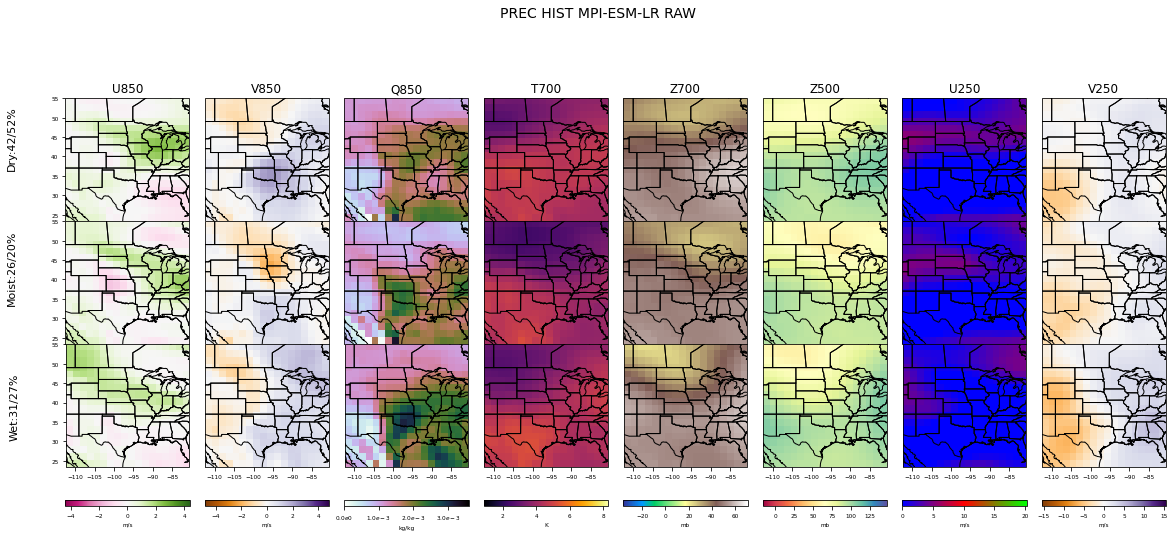

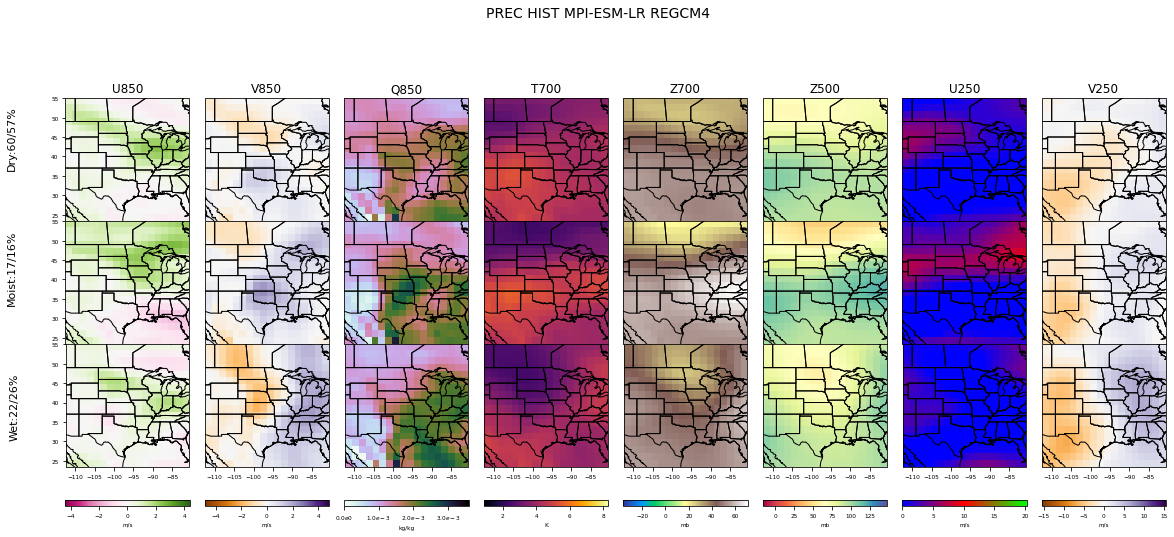

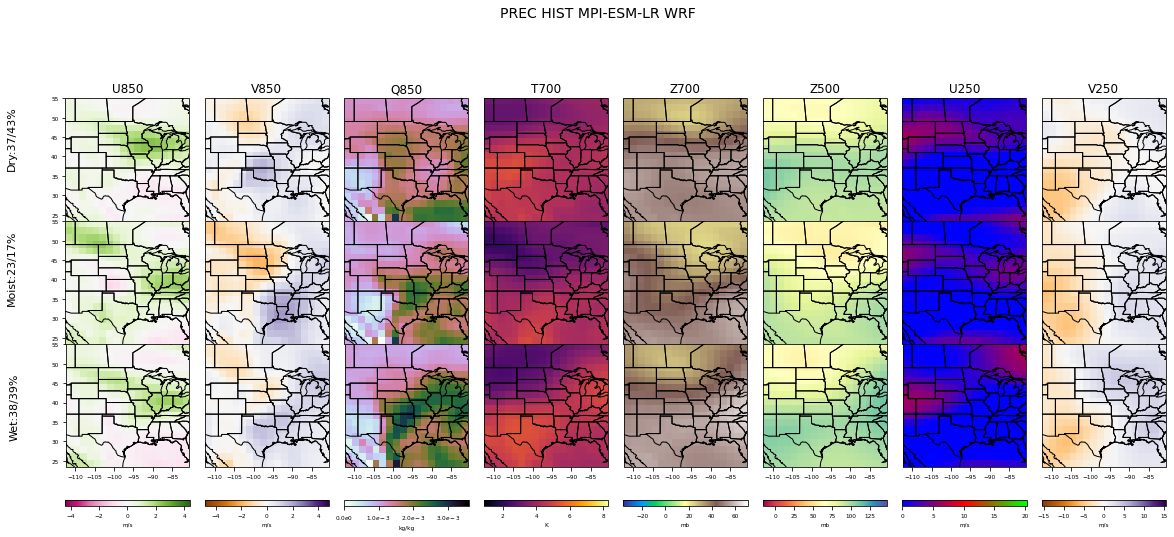

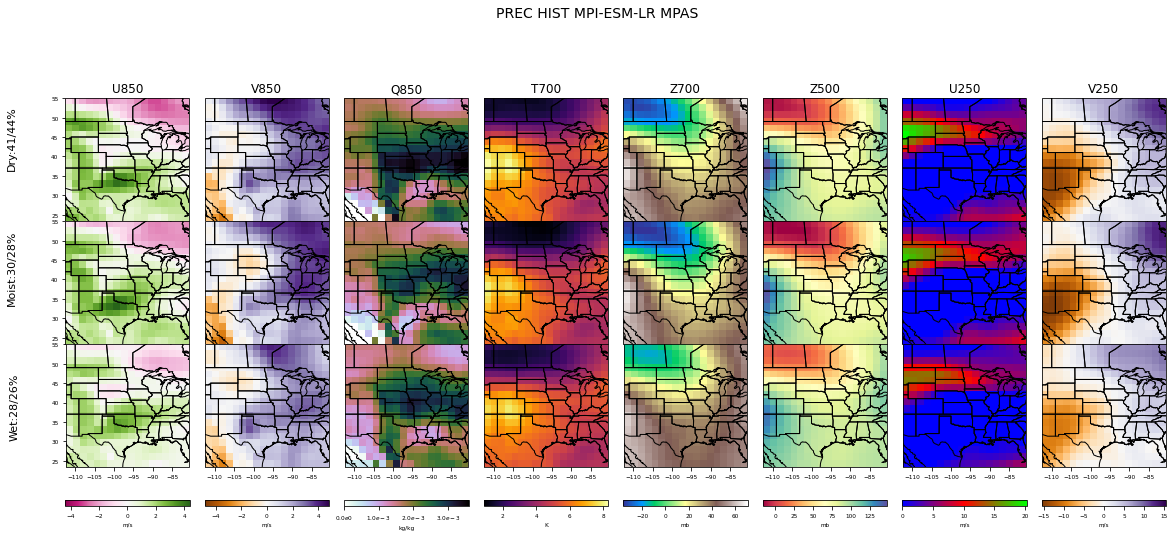

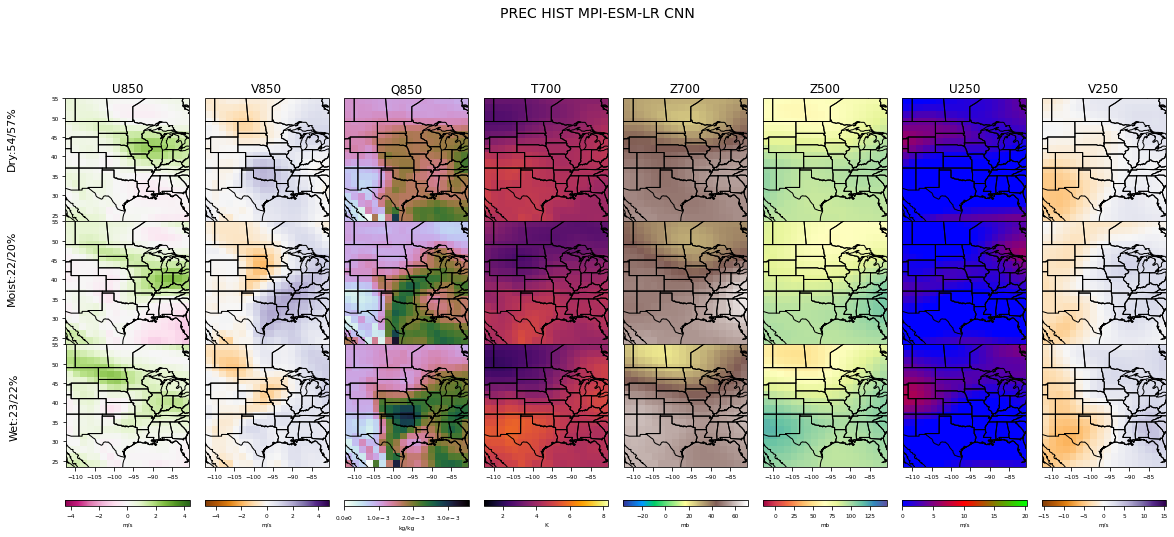

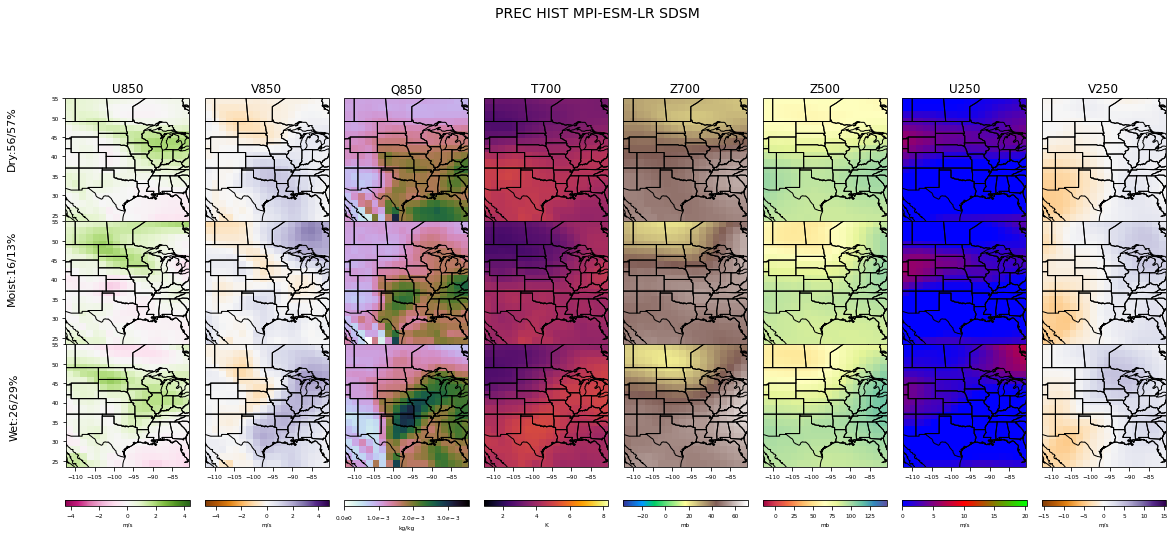

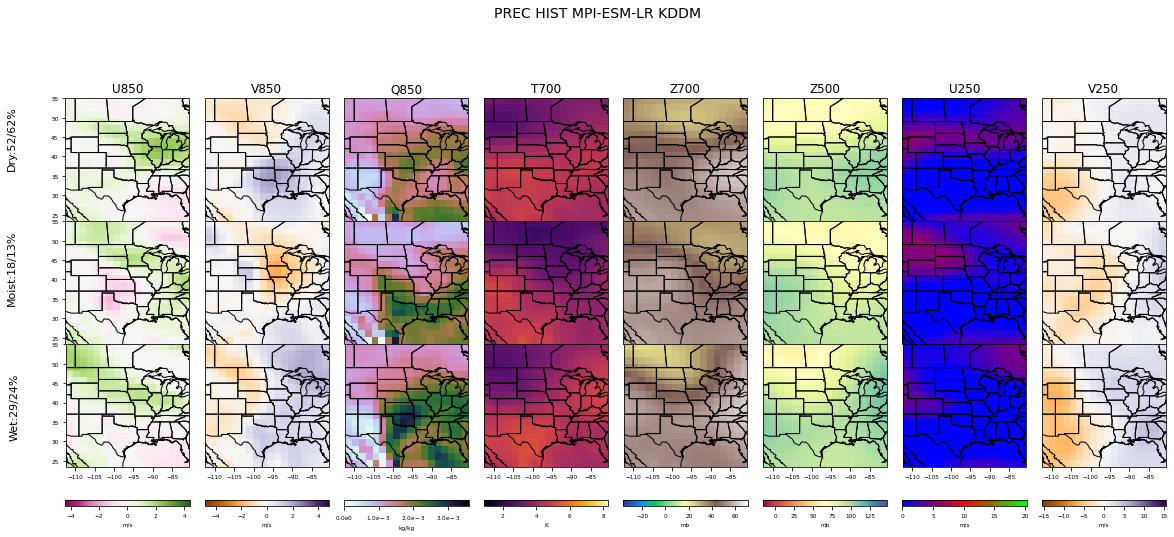

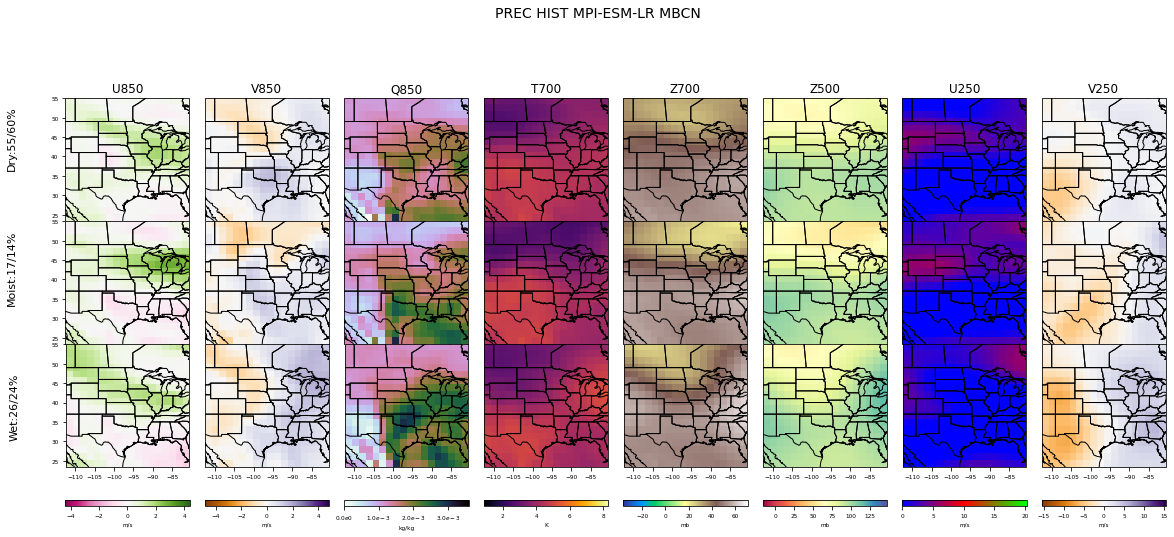

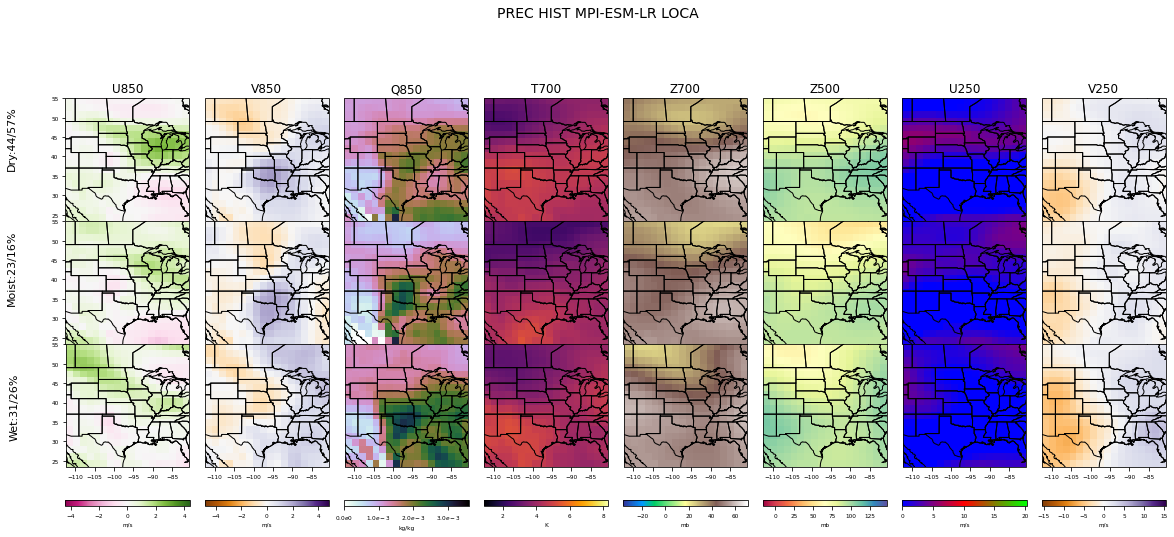

In [21]:
# plot mpi dry/moist/wet: hist
#sigfiles_hist = list(filter(lambda line:'hist' in line, mpi_sigfiles))
sigfiles_hist = [model2absfilepath(ff, 'hist', 98, 36) for ff in ['raw','RegCM4','WRF','MPAS','CNN','SDSM','KDDM','MBCn','LOCA']]
sigfiles_rcp85 = [model2absfilepath(ff, 'rcp85', 98, 36) for ff in ['raw','RegCM4','WRF','MPAS','CNN','SDSM','KDDM','MBCn','LOCA']]

#plot_models(sigfiles_hist, vmin, vmax)
plot_diff_postage(sigfiles_hist, sigfiles_rcp85, vmin, vmax)


In [ ]:
3